In [ ]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

from scipy.special import erfcinv

import numpy as np

import sys, os
#sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))
#from tensiometer import utilities

def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Three moltivariate distributions

In [70]:
#Fixed Parameters
num_parameters = 2
num_datasets = 3

#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

num_samples = 10000

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=num_samples)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=num_samples)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=num_samples)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')


# Anova-like stimators

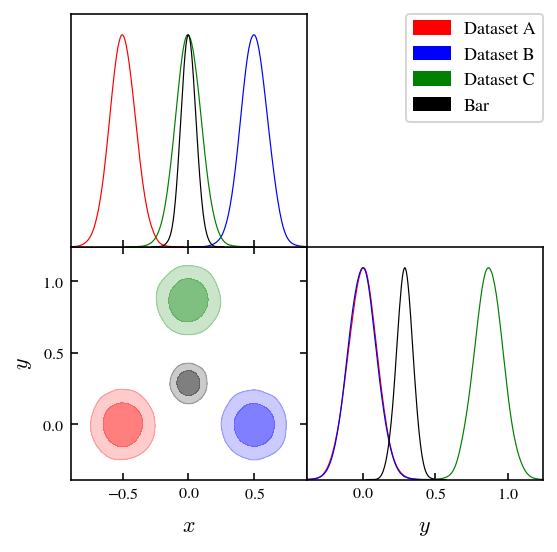

In [ ]:
#mean_bar = (mean_A + mean_B + mean_C)/num_datasets

cov_tot = cov_A + cov_B + cov_C
#cov_bar = cov_tot / num_datasets**2

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C], [cov_A, cov_B, cov_C])
mean_bar = centroid
cov_bar = centroid_covariance


delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=num_samples)
chain_bar = MCSamples(samples=samps_bar, names=names, labels=labels, label='Bar')

colors = ['red', 'blue', 'green', 'black']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_bar],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
plt.savefig('triangle_plot_1_centroid.pdf')


In [ ]:
samps_A_H0 = np.random.multivariate_normal(0*mean_A, cov_A, size=num_samples)
samps_B_H0 = np.random.multivariate_normal(0*mean_B, cov_B, size=num_samples)
samps_C_H0 = np.random.multivariate_normal(0*mean_C, cov_C, size=num_samples)
samps_bar_H0 = np.random.multivariate_normal(0*mean_bar, cov_bar, size=num_samples)

samps_delta_theta_AB_H0 = samps_A_H0 - samps_B_H0
samps_delta_theta_AC_H0 = samps_A_H0 - samps_C_H0
samps_delta_theta_BC_H0 = samps_B_H0 - samps_C_H0


samps_delta_theta_A_H0 = samps_A_H0 - samps_bar_H0
samps_delta_theta_B_H0 = samps_B_H0 - samps_bar_H0
samps_delta_theta_C_H0 = samps_C_H0 - samps_bar_H0


## $\alpha$-stimator

\begin{equation}
    \alpha = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\sum_{j} C_j}  (\theta_i - \bar{\theta})
\end{equation}

alpha: 33.33333333333333
[0.92083751 1.61177706 1.75596737 ... 3.91016592 3.87122776 3.6077124 ]
PTE: 0.0
$N \sigma$: inf


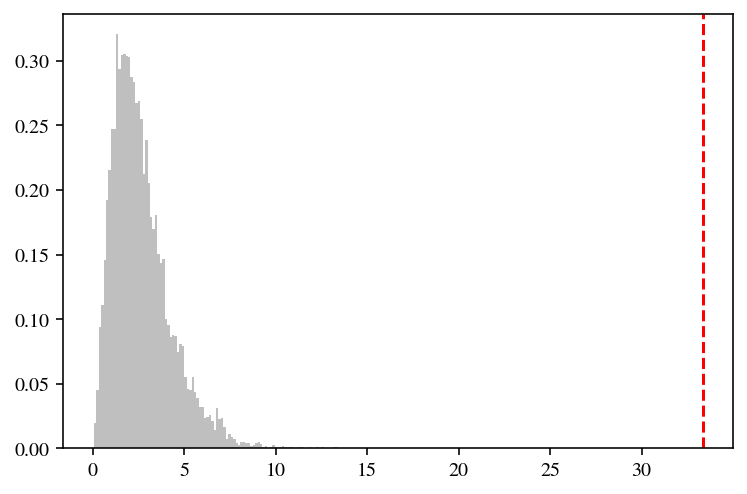

In [74]:
# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)

alpha = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C))

print(r'alpha: {}'.format(alpha))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_A_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_A_H0[i,:])) \
    + np.dot(samps_delta_theta_B_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_B_H0[i,:]))\
    + np.dot(samps_delta_theta_C_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_C_H0[i,:]))


plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(alpha, color='red', linestyle='--', label='alpha')

print(samples_H0)
PTE = samples_H0[samples_H0 > alpha].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))

## $\beta$-stimator

\begin{equation}
    \beta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j)
\end{equation}

beta: 150.0
[ 2.09782963  5.71625831  1.85525183 ...  6.25295878  5.13453255
 12.26499075]
PTE: 0.0
$N \sigma$: inf


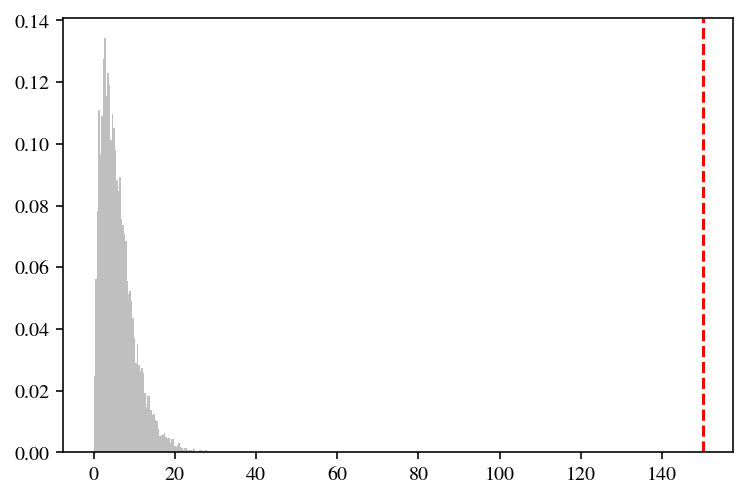

In [ ]:
beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
    + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
    + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))

print(r'beta: {}'.format(beta))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_AB_H0[i,:].T,np.dot(np.linalg.inv(cov_A + cov_B), samps_delta_theta_AB_H0[i,:])) \
    + np.dot(samps_delta_theta_AC_H0[i,:].T,np.dot(np.linalg.inv(cov_A + cov_C), samps_delta_theta_AC_H0[i,:]))\
    + np.dot(samps_delta_theta_BC_H0[i,:].T,np.dot(np.linalg.inv(cov_B + cov_C), samps_delta_theta_BC_H0[i,:]))


samples_H0 = np.array(samples_H0)
plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(beta, color='red', linestyle='--', label='beta')

print(samples_H0)
PTE = samples_H0[samples_H0 > beta].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))

## $\gamma$-stimator

\begin{equation}
    \gamma = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_{i}}  (\theta_i - \bar{\theta})
\end{equation}

gamma: 99.99999999999999
[ 2.76251252  4.83533117  5.2679021  ... 11.73049775 11.61368329
 10.82313721]
PTE: 0.0
$N \sigma$: inf


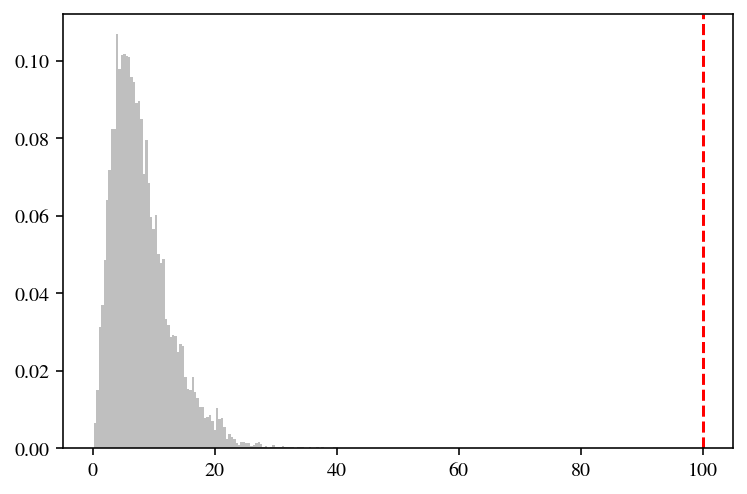

In [84]:
gamma = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C))

print(r'gamma: {}'.format(gamma))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_A_H0[i,:].T,np.dot(np.linalg.inv(cov_A), samps_delta_theta_A_H0[i,:])) \
    + np.dot(samps_delta_theta_B_H0[i,:].T,np.dot(np.linalg.inv(cov_B), samps_delta_theta_B_H0[i,:]))\
    + np.dot(samps_delta_theta_C_H0[i,:].T,np.dot(np.linalg.inv(cov_C), samps_delta_theta_C_H0[i,:]))


samples_H0 = np.array(samples_H0)
plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(gamma, color='red', linestyle='--', label='gamma')

print(samples_H0)
PTE = samples_H0[samples_H0 > gamma].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))

## $\delta$-stimator

\begin{equation}
    \delta = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\bar{C}}  (\theta_i - \bar{\theta}) = n^{2} \cdot \alpha
\end{equation}

delta: 300.0
[ 8.28753757 14.50599351 15.80370629 ... 35.19149326 34.84104987
 32.46941162]
PTE: 0.0
$N \sigma$: inf


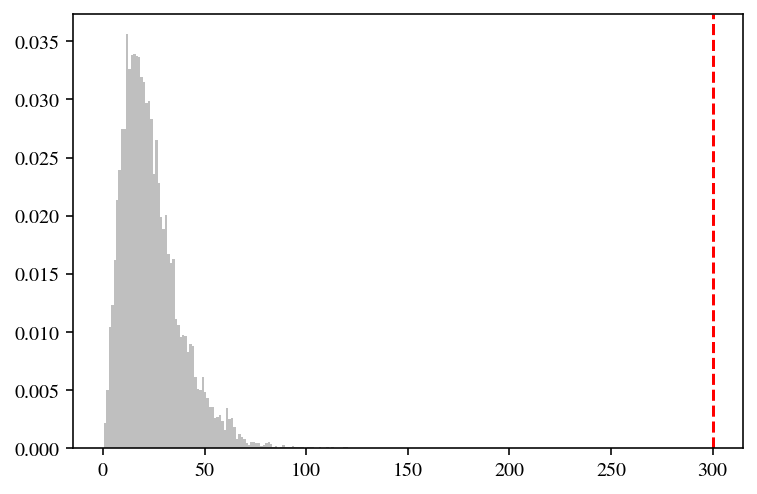

In [ ]:
A_matrix = np.linalg.inv(cov_bar)

delta = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C))
print(r'delta: {}'.format(delta))


samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_A_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_A_H0[i,:])) \
    + np.dot(samps_delta_theta_B_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_B_H0[i,:]))\
    + np.dot(samps_delta_theta_C_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_C_H0[i,:]))


plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(delta, color='red', linestyle='--', label='delta')

print(samples_H0)
PTE = samples_H0[samples_H0 > delta].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))



## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

epsilon: 75.0
[2.07188439 3.62649838 3.95092657 ... 8.79787331 8.71026247 8.11735291]
PTE: 0.0
$N \sigma$: inf


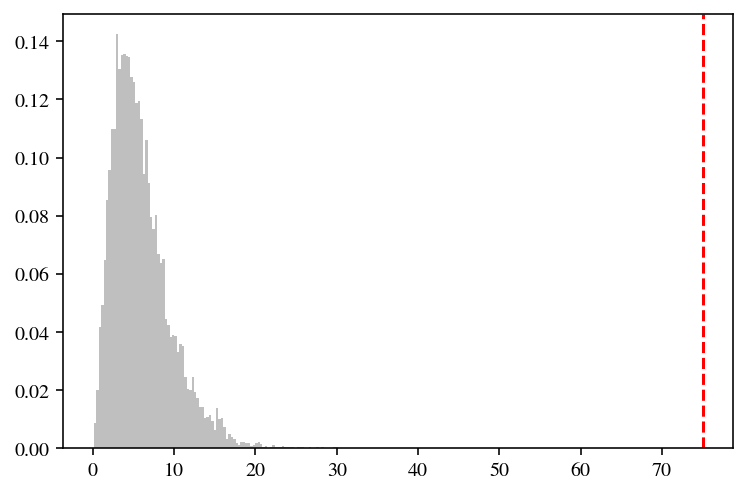

In [ ]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))
print(r'epsilon: {}'.format(epsilon))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_A_H0[i,:].T,np.dot(np.linalg.inv(cov_A + cov_bar), samps_delta_theta_A_H0[i,:])) \
    + np.dot(samps_delta_theta_B_H0[i,:].T,np.dot(np.linalg.inv(cov_B + cov_bar), samps_delta_theta_B_H0[i,:]))\
    + np.dot(samps_delta_theta_C_H0[i,:].T,np.dot(np.linalg.inv(cov_C + cov_bar), samps_delta_theta_C_H0[i,:]))


samples_H0 = np.array(samples_H0)
plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(epsilon, color='red', linestyle='--', label='epsilon')

print(samples_H0)
PTE = samples_H0[samples_H0 > epsilon].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))